In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(image_path):
    img = image.load_img(image_path)
    img_array = image.img_to_array(img)
    return img_array/255.0

X, y = [], []

for _ in ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']:
    for image_name in os.listdir(f'/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/{_}'):
        image_path = os.path.join((f'/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/{_}'), image_name)
        X.append(load_and_preprocess_image(image_path))
        y.append(_)
        
X = np.asarray(X)
y = np.asarray(y)

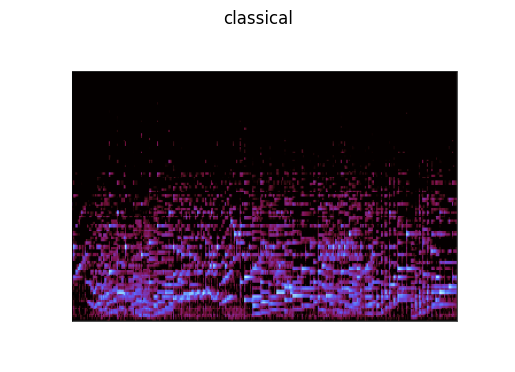

In [4]:
def view_random_image(rand_idx = -1):
    if rand_idx==-1:
        rand_idx = np.random.randint(0, high=X.shape[0])
    plt.imshow(cv2.cvtColor(X[rand_idx], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(y[rand_idx])
    plt.show()

view_random_image()

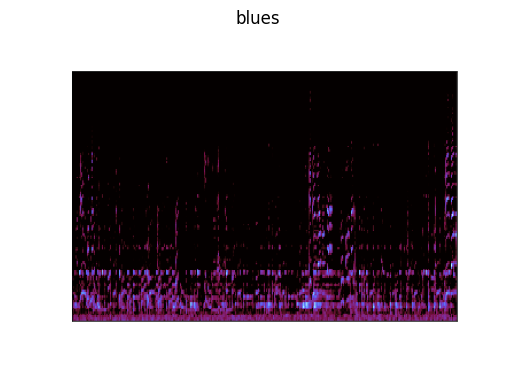

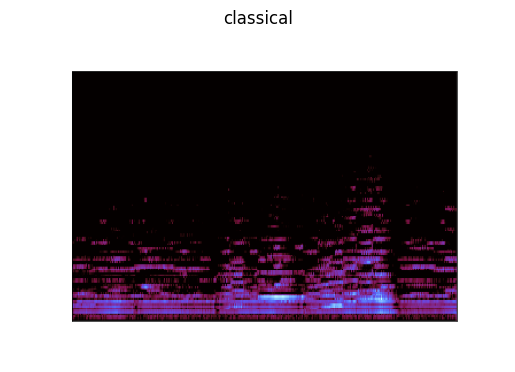

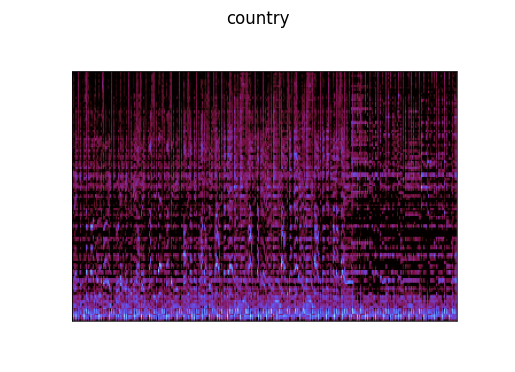

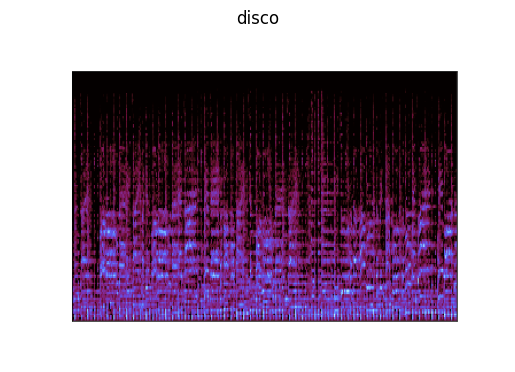

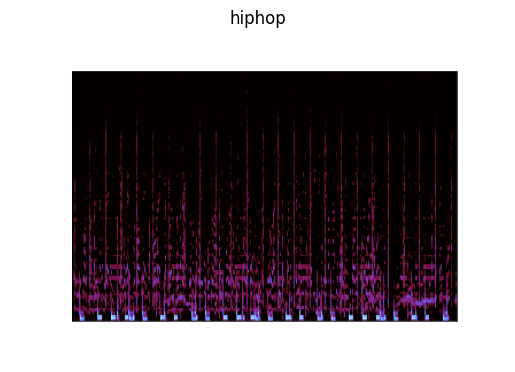

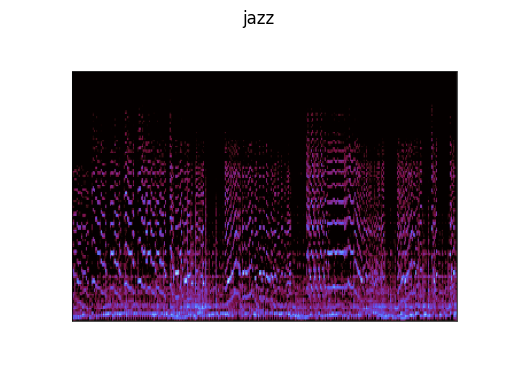

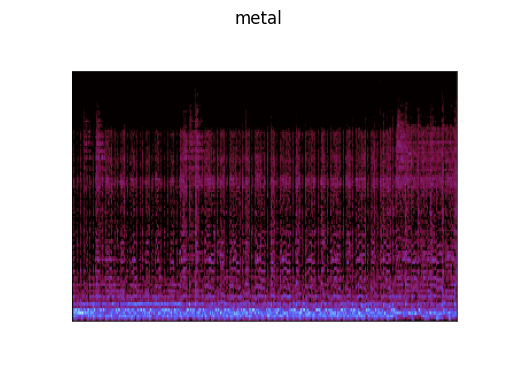

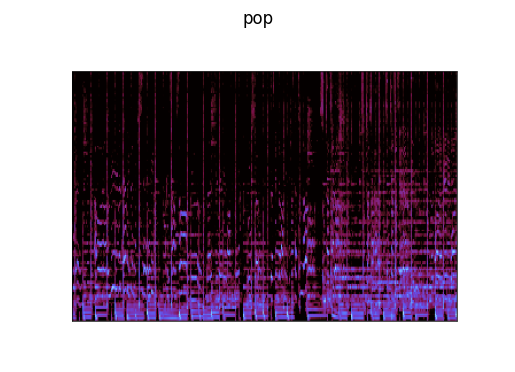

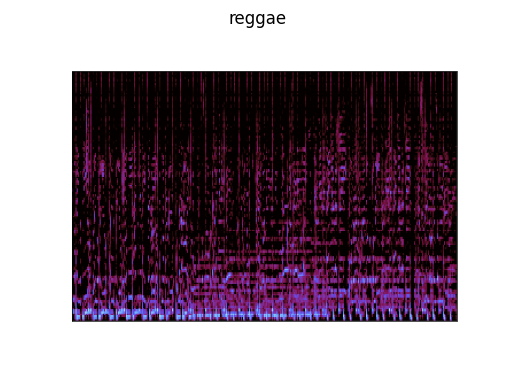

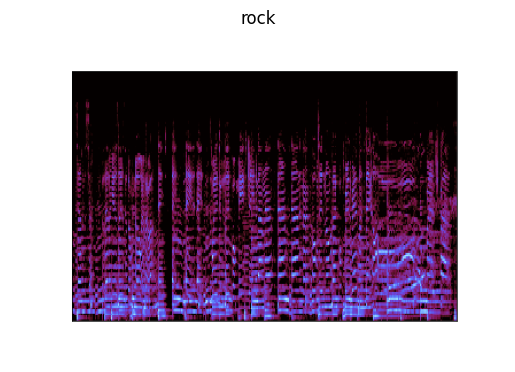

In [5]:
for _ in range(1, 902, 100):
    view_random_image(_)

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15,
                                                    random_state=42,
                                                    stratify=y)

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16

In [17]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(288, 432, 3))

for layer in base_model.layers[2:-2]:
    layer.trainable = False

model = tf.keras.Sequential(
    layers=[
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='softmax')
    ]
)

model.build((999, 288, 432, 3))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 13, 512)        14714688  
                                                                 
 flatten_4 (Flatten)         (None, 59904)             0         
                                                                 
 dense_6 (Dense)             (None, 10)                599050    
                                                                 
Total params: 15313738 (58.42 MB)
Trainable params: 2960650 (11.29 MB)
Non-trainable params: 12353088 (47.12 MB)
_________________________________________________________________


In [22]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
              metrics='accuracy'
             )

history = model.fit(X_train, y_train, 
                    batch_size=16,
                    validation_data=(X_test, y_test),
                    epochs=200,
                    callbacks=EarlyStopping(patience=10))

Epoch 1/200
54/54 [==============================] - 12s 189ms/step - loss: 896.7200 - accuracy: 0.9458 - val_loss: 2.7030 - val_accuracy: 0.6667
Epoch 2/200
54/54 [==============================] - 10s 184ms/step - loss: 404.2470 - accuracy: 0.9941 - val_loss: 2.0829 - val_accuracy: 0.7200
Epoch 3/200
54/54 [==============================] - 10s 185ms/step - loss: 1441.6827 - accuracy: 0.9929 - val_loss: 2.5700 - val_accuracy: 0.6933
Epoch 4/200
54/54 [==============================] - 10s 186ms/step - loss: 50.6719 - accuracy: 0.9929 - val_loss: 2.7339 - val_accuracy: 0.6800
Epoch 5/200
54/54 [==============================] - 10s 185ms/step - loss: 448.9966 - accuracy: 0.9894 - val_loss: 2.6645 - val_accuracy: 0.6933
Epoch 6/200
54/54 [==============================] - 10s 185ms/step - loss: 0.0633 - accuracy: 0.9859 - val_loss: 2.6110 - val_accuracy: 0.7200
Epoch 7/200
54/54 [==============================] - 10s 185ms/step - loss: 996.5836 - accuracy: 0.9976 - val_loss: 2.4424 - v

In [37]:
#saving the model
model.save('VGG16-GTZAN.keras')

In [32]:
y_pred = []
for i in model.predict(X_test):
    y_pred.append(np.argmax(i))

5/5 [==============================] - 1s 154ms/step


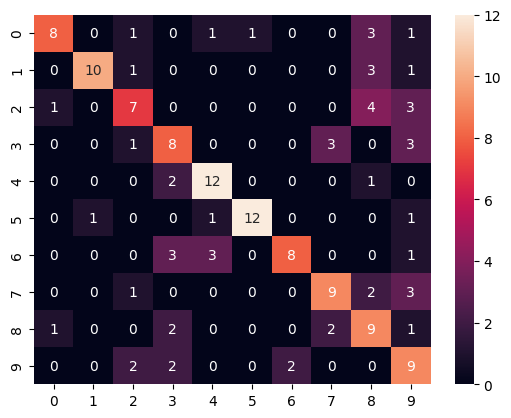

In [35]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()